# Image Classification

In this notebook, we will classify different kinds of beverages you might find in the fridge.

Check out fastai version.

In [1]:
import fastai
fastai.__version__

'1.0.45'

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path

---

## File Structure for Image Classification

In this repo, there is a `data` folder inside the `image_classification` directory, in which you'll find a directory titled: __singlelabel_fridge_objects__. This is the data that we'll use in this notebook. 

Lets set that directory to our `path` variable, which we'll use throughout the notebook, and checkout what's inside:

In [4]:
path = Path('../data/singlelabel_fridge_objects')
path.ls()

[PosixPath('../data/singlelabel_fridge_objects/models'),
 PosixPath('../data/singlelabel_fridge_objects/milk_bottle'),
 PosixPath('../data/singlelabel_fridge_objects/carton'),
 PosixPath('../data/singlelabel_fridge_objects/water_bottle'),
 PosixPath('../data/singlelabel_fridge_objects/can')]

You'll notice that we have four different folders inside:
- `/milk_bottle`
- `/carton`
- `/water_bottle`
- `/can`

In this classification exercise, these four folders will be the four classes we try to classify.

Lets make sure that the contents of those folders look correct. We'll simply print out some of the elements inside one of the directory. Lets see what's inside the `/can` directory.

In [5]:
(path/'can').ls()[:5]

[PosixPath('../data/singlelabel_fridge_objects/can/16.jpg'),
 PosixPath('../data/singlelabel_fridge_objects/can/4.jpg'),
 PosixPath('../data/singlelabel_fridge_objects/can/11.jpg'),
 PosixPath('../data/singlelabel_fridge_objects/can/17.jpg'),
 PosixPath('../data/singlelabel_fridge_objects/can/21.jpg')]

The most common data format for multiclass image classification is to have a folder titled the label with the images inside:

```
/images
+-- can (class 1)
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- carton (class 2)
|   +-- image31.jpg
|   +-- image32.jpg
|   +-- ...
+-- ...
```

Good thing our data is already structured in that format!

## Loading images with fast.ai

To use fastai, we want to create an ImageDataBunch so that the library can easily use multiple images (mini-batches) during training time. We create an ImageDataBunch by using fastai's [data_block apis](https://docs.fast.ai/data_block.html).

In [6]:
np.random.seed(42)
src = ImageItemList \
    .from_folder(path) \
    .random_split_by_pct(valid_pct=0.2, seed=10) \
    .label_from_folder()

In [7]:
data = src \
    .transform(size=128) \
    .databunch(bs=24) \
    .normalize(imagenet_stats)

Lets take a look at our data using the databunch we created.

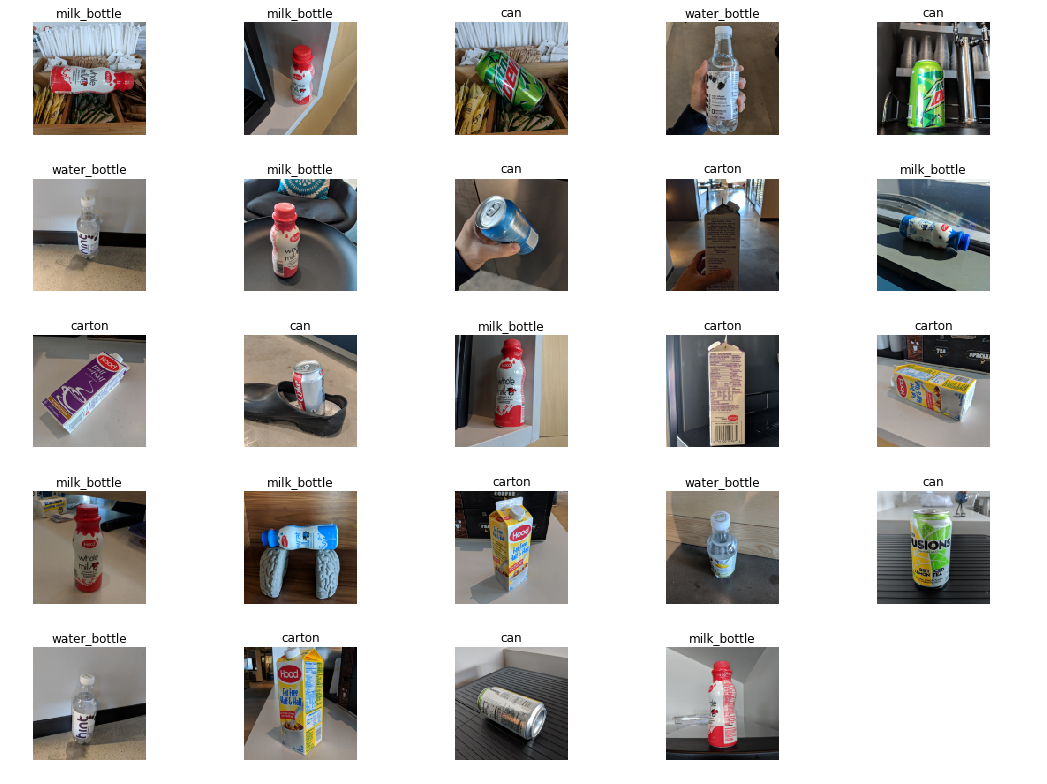

In [8]:
data.show_batch(rows=5, figsize=(15,11))

Lets see all available classes:

In [9]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 4
['can', 'carton', 'milk_bottle', 'water_bottle']


## Training/Evaluating (part 1)
In as few lines of code as possible, lets build a model to classify dog and cat breeds. 

#### Training
For the model, we use a concolutional neural network. 

When training a model, there are many hypter parameters to select, such as the learning rate, the model architecture, layers to tune, and many more. 

With fastai, we can use the `create_cnn` function that allows us to specify the model architecture and a performance indicator (metric). At this point, we already benefit from transfer learning since we download the parameters used to train imagenet. 

In [10]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

We can call the `fit` function to train the last layer of the dnn.

In [11]:
learn.fit(2)

epoch,train_loss,valid_loss,error_rate
1,1.480766,1.129238,0.500000
2,0.956168,0.528203,0.192308


Lets save our model at this point. When we run the command below, we save our model to the `path` variable which we used to create our ImageDataBunch. We can automatically reload our model by running `learn.load("part-1")`.

In [12]:
learn.save("part-1")

Not bad. In just one line of code, we're down to a pretty low error rate.

#### Evaluating

When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

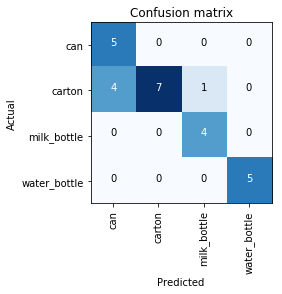

In [14]:
interp.plot_confusion_matrix()

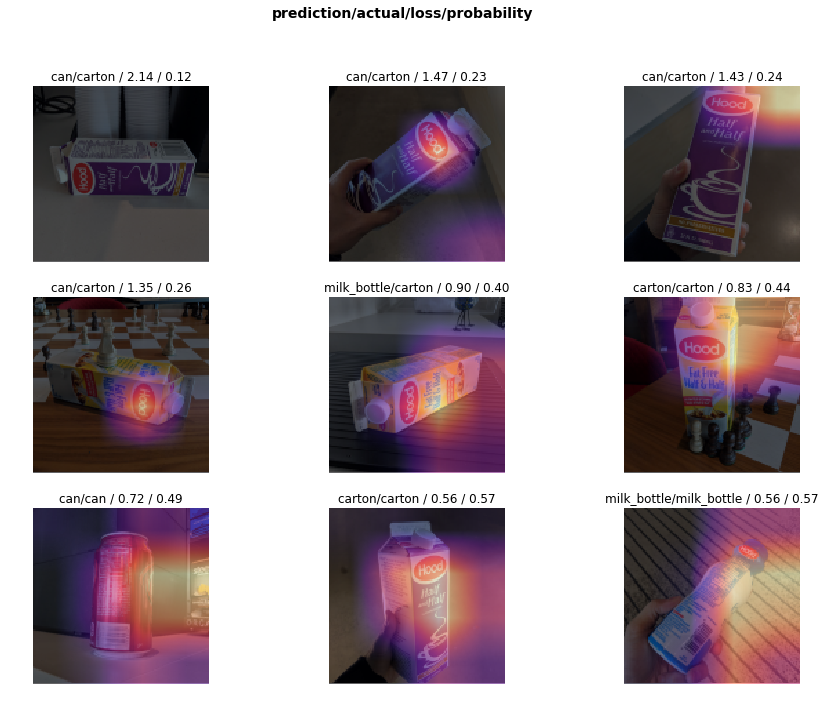

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

We can also see which classes the model got most mixed up.

In [16]:
interp.most_confused()

[('carton', 'can', 4), ('carton', 'milk_bottle', 1)]

## Training/Evaluating (part 2)

We've already trained the last layer of our model over a few epochs of the dataset so our weights on the last layer are already pretty reasonable. 

But lets see if we can do better using three techniques:
1. choosing the right learning rate
1. `fit_one_cycle` instead of `fit`
1. unfreeze layers and retrain

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06


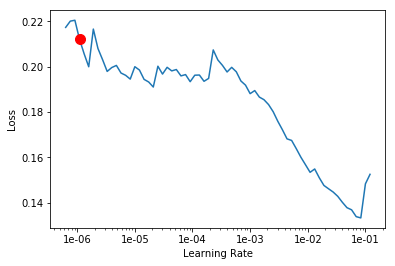

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate
1,0.137523,0.428426,0.115385
2,0.124220,0.395321,0.115385


When you unfreeze your model, all the parameters in all layers of the model can be adjusted. So it is possible that the error_rate increase initially before decreasing again.

In [20]:
learn.unfreeze()

Lets tune our learning rate again now that we've unfrozen the layers.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06


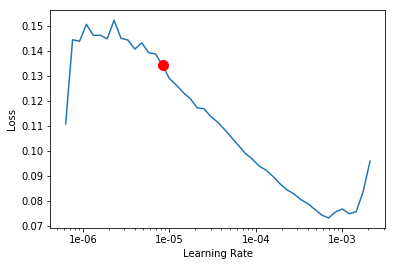

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.173992,0.364608,0.153846
2,0.185840,0.322590,0.115385


In [23]:
learn.save("part-2")

Much more accurate!

## Training/Evaluation (part 3)

To improve out model performance even further, we can try using 
1. a deeper architecture (resnet50 instead of resnet34)
1. a higher resolution image size
1. data augmentation

We'll use image size 299X299 instead of 99X99:

In [24]:
data = src \
    .transform(get_transforms(), size=299) \
    .databunch(bs=16) \
    .normalize(imagenet_stats)

Lets use resnet50 instead of resnet 34:

In [25]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Find a good learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04


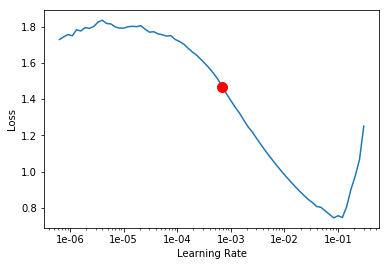

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate
1,1.476367,0.660936,0.153846
2,0.829850,0.377620,0.076923


In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.257446,0.200171,0.000000
2,0.161259,0.122631,0.038462


In [30]:
learn.save('part-3')

Lets re-evaluate our model.

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

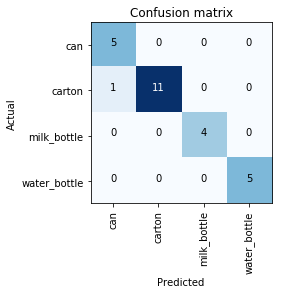

In [32]:
interp.plot_confusion_matrix()

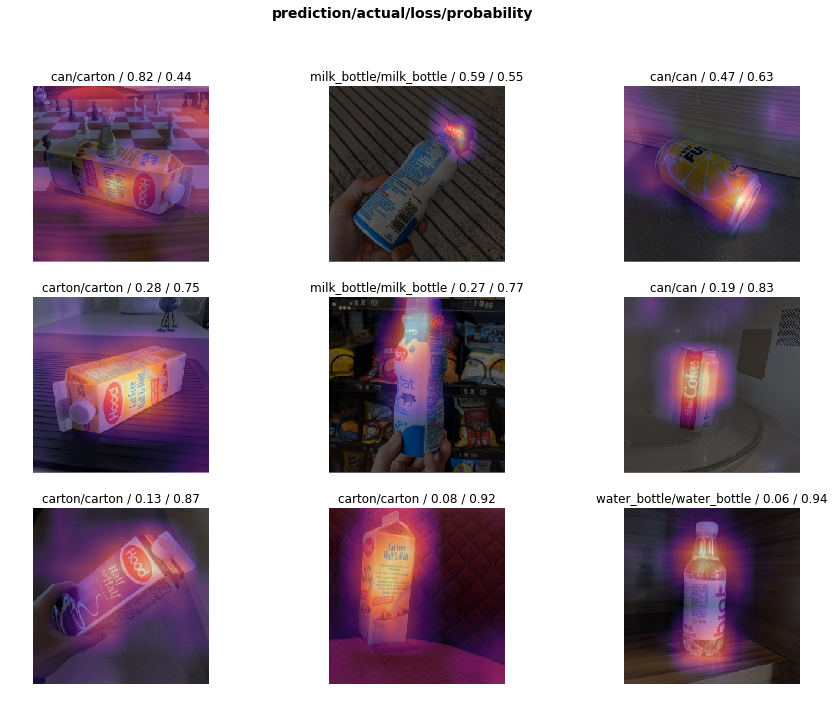

In [33]:
interp.plot_top_losses(9, figsize=(15,11))

## Recap
To recap our modeling steps:

1. First we want to just see how well our model performs with default settings so that we have a baseline to improve on.
1. Then we want to unfreeze layers and choose an optimal learning rate.
1. Finally we can try deeper architectures, higher resolution images, and data augmentation.